# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [43]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

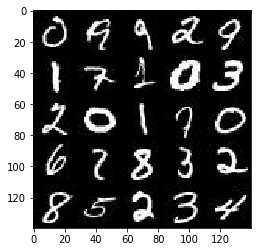

In [44]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

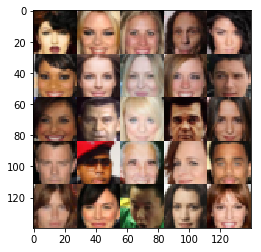

In [45]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [47]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [49]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [57]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    with tf.variable_scope('generator',reuse=not is_train):
        # full connected layer
        x1 = tf.layers.dense(z, (7*7*512))
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = leaky_relu(x1)
        
        # input size is 7x7x512
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        
        # input size is 14x14x256
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        
        # input size is 28x28x128
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = leaky_relu(x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [58]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [59]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [60]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [61]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    images_count, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Batch 10... Discriminator Loss: 0.3704... Generator Loss: 16.9546
Epoch 1/2... Batch 20... Discriminator Loss: 2.3685... Generator Loss: 4.2399
Epoch 1/2... Batch 30... Discriminator Loss: 0.6935... Generator Loss: 1.7198
Epoch 1/2... Batch 40... Discriminator Loss: 1.7557... Generator Loss: 1.6668
Epoch 1/2... Batch 50... Discriminator Loss: 1.1038... Generator Loss: 0.8398
Epoch 1/2... Batch 60... Discriminator Loss: 1.1672... Generator Loss: 0.9668
Epoch 1/2... Batch 70... Discriminator Loss: 1.2538... Generator Loss: 1.7643
Epoch 1/2... Batch 80... Discriminator Loss: 1.2579... Generator Loss: 0.6822
Epoch 1/2... Batch 90... Discriminator Loss: 1.4498... Generator Loss: 0.6744
Epoch 1/2... Batch 100... Discriminator Loss: 1.0678... Generator Loss: 1.6548


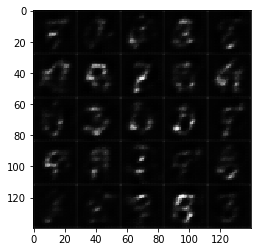

Epoch 1/2... Batch 110... Discriminator Loss: 1.2868... Generator Loss: 0.8328
Epoch 1/2... Batch 120... Discriminator Loss: 1.2502... Generator Loss: 0.9921
Epoch 1/2... Batch 130... Discriminator Loss: 1.7638... Generator Loss: 2.9066
Epoch 1/2... Batch 140... Discriminator Loss: 1.2296... Generator Loss: 0.7814
Epoch 1/2... Batch 150... Discriminator Loss: 1.2807... Generator Loss: 0.6878
Epoch 1/2... Batch 160... Discriminator Loss: 1.2070... Generator Loss: 1.2311
Epoch 1/2... Batch 170... Discriminator Loss: 1.3415... Generator Loss: 0.5983
Epoch 1/2... Batch 180... Discriminator Loss: 1.6465... Generator Loss: 0.3736
Epoch 1/2... Batch 190... Discriminator Loss: 1.1592... Generator Loss: 1.1119
Epoch 1/2... Batch 200... Discriminator Loss: 1.2487... Generator Loss: 0.8676


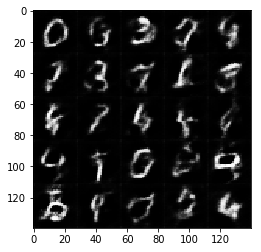

Epoch 1/2... Batch 210... Discriminator Loss: 1.6467... Generator Loss: 0.3754
Epoch 1/2... Batch 220... Discriminator Loss: 1.2320... Generator Loss: 0.8079
Epoch 1/2... Batch 230... Discriminator Loss: 1.2093... Generator Loss: 0.9281
Epoch 1/2... Batch 240... Discriminator Loss: 1.4585... Generator Loss: 0.5191
Epoch 1/2... Batch 250... Discriminator Loss: 1.3368... Generator Loss: 0.6704
Epoch 1/2... Batch 260... Discriminator Loss: 1.2406... Generator Loss: 1.2247
Epoch 1/2... Batch 270... Discriminator Loss: 1.1359... Generator Loss: 1.0646
Epoch 1/2... Batch 280... Discriminator Loss: 1.3024... Generator Loss: 0.6707
Epoch 1/2... Batch 290... Discriminator Loss: 1.3709... Generator Loss: 0.5584
Epoch 1/2... Batch 300... Discriminator Loss: 1.2351... Generator Loss: 0.7085


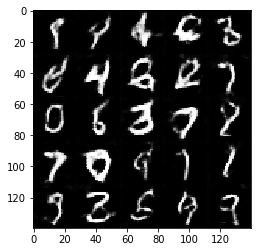

Epoch 1/2... Batch 310... Discriminator Loss: 1.1374... Generator Loss: 1.0345
Epoch 1/2... Batch 320... Discriminator Loss: 1.3282... Generator Loss: 0.5729
Epoch 1/2... Batch 330... Discriminator Loss: 1.2475... Generator Loss: 0.7087
Epoch 1/2... Batch 340... Discriminator Loss: 1.7914... Generator Loss: 0.3479
Epoch 1/2... Batch 350... Discriminator Loss: 1.2731... Generator Loss: 0.8184
Epoch 1/2... Batch 360... Discriminator Loss: 1.4601... Generator Loss: 1.5639
Epoch 1/2... Batch 370... Discriminator Loss: 1.2276... Generator Loss: 0.8131
Epoch 1/2... Batch 380... Discriminator Loss: 1.2781... Generator Loss: 0.8981
Epoch 1/2... Batch 390... Discriminator Loss: 1.5430... Generator Loss: 0.4660
Epoch 1/2... Batch 400... Discriminator Loss: 1.1367... Generator Loss: 1.1141


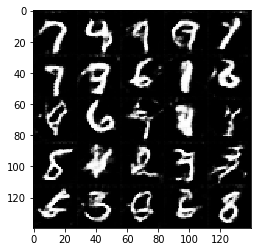

Epoch 1/2... Batch 410... Discriminator Loss: 1.3277... Generator Loss: 0.6755
Epoch 1/2... Batch 420... Discriminator Loss: 1.3748... Generator Loss: 0.6714
Epoch 1/2... Batch 430... Discriminator Loss: 1.5192... Generator Loss: 1.8087
Epoch 1/2... Batch 440... Discriminator Loss: 1.1791... Generator Loss: 0.7902
Epoch 1/2... Batch 450... Discriminator Loss: 1.2777... Generator Loss: 0.8379
Epoch 1/2... Batch 460... Discriminator Loss: 1.2741... Generator Loss: 0.7200
Epoch 2/2... Batch 10... Discriminator Loss: 1.2656... Generator Loss: 0.8144
Epoch 2/2... Batch 20... Discriminator Loss: 1.2179... Generator Loss: 0.8868
Epoch 2/2... Batch 30... Discriminator Loss: 1.2420... Generator Loss: 1.0541
Epoch 2/2... Batch 40... Discriminator Loss: 1.2355... Generator Loss: 0.8541
Epoch 2/2... Batch 50... Discriminator Loss: 1.1666... Generator Loss: 1.1900
Epoch 2/2... Batch 60... Discriminator Loss: 1.2075... Generator Loss: 1.3491
Epoch 2/2... Batch 70... Discriminator Loss: 1.3251... Gen

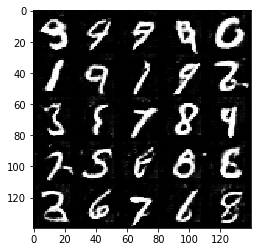

Epoch 2/2... Batch 110... Discriminator Loss: 1.3860... Generator Loss: 0.5631
Epoch 2/2... Batch 120... Discriminator Loss: 1.3268... Generator Loss: 0.6079
Epoch 2/2... Batch 130... Discriminator Loss: 1.3637... Generator Loss: 1.5737
Epoch 2/2... Batch 140... Discriminator Loss: 1.3187... Generator Loss: 0.6285
Epoch 2/2... Batch 150... Discriminator Loss: 1.1363... Generator Loss: 0.9427
Epoch 2/2... Batch 160... Discriminator Loss: 1.8386... Generator Loss: 0.3418
Epoch 2/2... Batch 170... Discriminator Loss: 1.2220... Generator Loss: 0.7525
Epoch 2/2... Batch 180... Discriminator Loss: 1.2872... Generator Loss: 1.1013
Epoch 2/2... Batch 190... Discriminator Loss: 1.1936... Generator Loss: 0.8819
Epoch 2/2... Batch 200... Discriminator Loss: 1.3039... Generator Loss: 0.6507


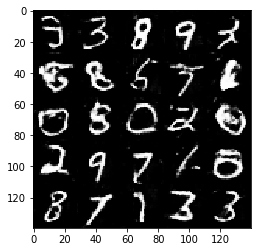

Epoch 2/2... Batch 210... Discriminator Loss: 1.4769... Generator Loss: 0.5124
Epoch 2/2... Batch 220... Discriminator Loss: 1.3189... Generator Loss: 0.6613
Epoch 2/2... Batch 230... Discriminator Loss: 1.2205... Generator Loss: 1.1076
Epoch 2/2... Batch 240... Discriminator Loss: 1.3052... Generator Loss: 0.6230
Epoch 2/2... Batch 250... Discriminator Loss: 1.3540... Generator Loss: 0.5717
Epoch 2/2... Batch 260... Discriminator Loss: 1.2487... Generator Loss: 0.7477
Epoch 2/2... Batch 270... Discriminator Loss: 1.5232... Generator Loss: 0.5205
Epoch 2/2... Batch 280... Discriminator Loss: 1.3339... Generator Loss: 0.6028
Epoch 2/2... Batch 290... Discriminator Loss: 1.1974... Generator Loss: 1.1921
Epoch 2/2... Batch 300... Discriminator Loss: 1.2962... Generator Loss: 0.9097


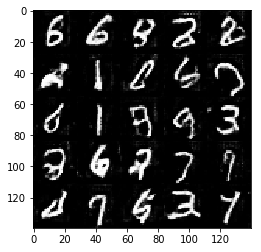

Epoch 2/2... Batch 310... Discriminator Loss: 1.4750... Generator Loss: 0.5284
Epoch 2/2... Batch 320... Discriminator Loss: 1.2275... Generator Loss: 0.7981
Epoch 2/2... Batch 330... Discriminator Loss: 1.1034... Generator Loss: 0.9729
Epoch 2/2... Batch 340... Discriminator Loss: 1.2648... Generator Loss: 1.2966
Epoch 2/2... Batch 350... Discriminator Loss: 1.2310... Generator Loss: 1.3007
Epoch 2/2... Batch 360... Discriminator Loss: 1.3194... Generator Loss: 0.6796
Epoch 2/2... Batch 370... Discriminator Loss: 1.4745... Generator Loss: 0.4749
Epoch 2/2... Batch 380... Discriminator Loss: 1.1407... Generator Loss: 1.2036
Epoch 2/2... Batch 390... Discriminator Loss: 1.1880... Generator Loss: 1.0554
Epoch 2/2... Batch 400... Discriminator Loss: 1.3046... Generator Loss: 1.2559


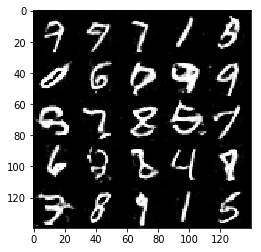

Epoch 2/2... Batch 410... Discriminator Loss: 1.2684... Generator Loss: 0.6782
Epoch 2/2... Batch 420... Discriminator Loss: 1.3118... Generator Loss: 0.7001
Epoch 2/2... Batch 430... Discriminator Loss: 1.3215... Generator Loss: 0.5957
Epoch 2/2... Batch 440... Discriminator Loss: 1.5428... Generator Loss: 2.0439
Epoch 2/2... Batch 450... Discriminator Loss: 1.2567... Generator Loss: 0.7055
Epoch 2/2... Batch 460... Discriminator Loss: 1.6671... Generator Loss: 0.4107


In [62]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Batch 10... Discriminator Loss: 5.0624... Generator Loss: 0.0197
Epoch 1/1... Batch 20... Discriminator Loss: 1.0147... Generator Loss: 1.5462
Epoch 1/1... Batch 30... Discriminator Loss: 1.7362... Generator Loss: 0.4910
Epoch 1/1... Batch 40... Discriminator Loss: 0.7411... Generator Loss: 1.6257
Epoch 1/1... Batch 50... Discriminator Loss: 0.7561... Generator Loss: 1.5440
Epoch 1/1... Batch 60... Discriminator Loss: 0.9842... Generator Loss: 1.3476
Epoch 1/1... Batch 70... Discriminator Loss: 0.4307... Generator Loss: 3.7399
Epoch 1/1... Batch 80... Discriminator Loss: 0.4210... Generator Loss: 4.9163
Epoch 1/1... Batch 90... Discriminator Loss: 0.7632... Generator Loss: 5.4539
Epoch 1/1... Batch 100... Discriminator Loss: 1.2731... Generator Loss: 2.4512


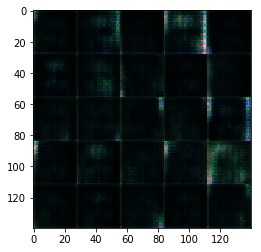

Epoch 1/1... Batch 110... Discriminator Loss: 1.5177... Generator Loss: 2.0905
Epoch 1/1... Batch 120... Discriminator Loss: 0.5759... Generator Loss: 1.7984
Epoch 1/1... Batch 130... Discriminator Loss: 0.9597... Generator Loss: 1.0133
Epoch 1/1... Batch 140... Discriminator Loss: 0.7146... Generator Loss: 1.6192
Epoch 1/1... Batch 150... Discriminator Loss: 1.5631... Generator Loss: 1.5479
Epoch 1/1... Batch 160... Discriminator Loss: 1.6172... Generator Loss: 0.8132
Epoch 1/1... Batch 170... Discriminator Loss: 0.9059... Generator Loss: 1.2205
Epoch 1/1... Batch 180... Discriminator Loss: 1.8776... Generator Loss: 0.5592
Epoch 1/1... Batch 190... Discriminator Loss: 1.0356... Generator Loss: 1.5702
Epoch 1/1... Batch 200... Discriminator Loss: 1.4702... Generator Loss: 0.6220


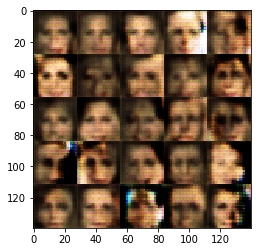

Epoch 1/1... Batch 210... Discriminator Loss: 1.2205... Generator Loss: 0.6007
Epoch 1/1... Batch 220... Discriminator Loss: 0.7266... Generator Loss: 1.3083
Epoch 1/1... Batch 230... Discriminator Loss: 1.0194... Generator Loss: 1.0369
Epoch 1/1... Batch 240... Discriminator Loss: 3.4532... Generator Loss: 5.2625
Epoch 1/1... Batch 250... Discriminator Loss: 1.3445... Generator Loss: 0.6958
Epoch 1/1... Batch 260... Discriminator Loss: 0.6175... Generator Loss: 1.5851
Epoch 1/1... Batch 270... Discriminator Loss: 1.4684... Generator Loss: 0.6123
Epoch 1/1... Batch 280... Discriminator Loss: 1.4408... Generator Loss: 0.4435
Epoch 1/1... Batch 290... Discriminator Loss: 1.1344... Generator Loss: 1.7416
Epoch 1/1... Batch 300... Discriminator Loss: 1.4401... Generator Loss: 0.6406


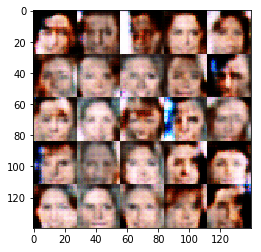

Epoch 1/1... Batch 310... Discriminator Loss: 0.8533... Generator Loss: 1.1090
Epoch 1/1... Batch 320... Discriminator Loss: 1.8488... Generator Loss: 2.6765
Epoch 1/1... Batch 330... Discriminator Loss: 0.4062... Generator Loss: 3.4069
Epoch 1/1... Batch 340... Discriminator Loss: 2.0840... Generator Loss: 0.2767
Epoch 1/1... Batch 350... Discriminator Loss: 0.6214... Generator Loss: 2.1146
Epoch 1/1... Batch 360... Discriminator Loss: 1.1145... Generator Loss: 0.7804
Epoch 1/1... Batch 370... Discriminator Loss: 0.4748... Generator Loss: 2.8360
Epoch 1/1... Batch 380... Discriminator Loss: 0.3828... Generator Loss: 6.1513
Epoch 1/1... Batch 390... Discriminator Loss: 0.8776... Generator Loss: 0.9764
Epoch 1/1... Batch 400... Discriminator Loss: 0.3852... Generator Loss: 5.2130


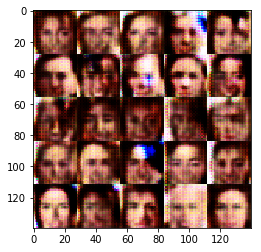

Epoch 1/1... Batch 410... Discriminator Loss: 0.5195... Generator Loss: 2.1138
Epoch 1/1... Batch 420... Discriminator Loss: 0.7137... Generator Loss: 1.4074
Epoch 1/1... Batch 430... Discriminator Loss: 1.7010... Generator Loss: 0.4328
Epoch 1/1... Batch 440... Discriminator Loss: 1.2036... Generator Loss: 0.7156
Epoch 1/1... Batch 450... Discriminator Loss: 1.2261... Generator Loss: 0.9832
Epoch 1/1... Batch 460... Discriminator Loss: 1.0828... Generator Loss: 1.0708
Epoch 1/1... Batch 470... Discriminator Loss: 1.4098... Generator Loss: 0.8082
Epoch 1/1... Batch 480... Discriminator Loss: 1.0430... Generator Loss: 1.1875
Epoch 1/1... Batch 490... Discriminator Loss: 1.2882... Generator Loss: 0.6415
Epoch 1/1... Batch 500... Discriminator Loss: 1.3116... Generator Loss: 1.8052


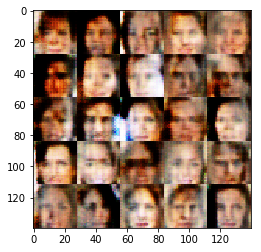

Epoch 1/1... Batch 510... Discriminator Loss: 0.5135... Generator Loss: 3.2619
Epoch 1/1... Batch 520... Discriminator Loss: 1.3010... Generator Loss: 2.0048
Epoch 1/1... Batch 530... Discriminator Loss: 0.8499... Generator Loss: 1.2748
Epoch 1/1... Batch 540... Discriminator Loss: 1.2035... Generator Loss: 0.7808
Epoch 1/1... Batch 550... Discriminator Loss: 1.1560... Generator Loss: 1.0669
Epoch 1/1... Batch 560... Discriminator Loss: 1.6856... Generator Loss: 0.4853
Epoch 1/1... Batch 570... Discriminator Loss: 1.4642... Generator Loss: 0.5737
Epoch 1/1... Batch 580... Discriminator Loss: 1.2847... Generator Loss: 0.7309
Epoch 1/1... Batch 590... Discriminator Loss: 1.1418... Generator Loss: 0.7816
Epoch 1/1... Batch 600... Discriminator Loss: 1.3676... Generator Loss: 1.1115


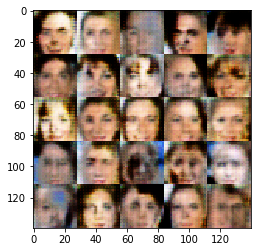

Epoch 1/1... Batch 610... Discriminator Loss: 1.5912... Generator Loss: 0.4233
Epoch 1/1... Batch 620... Discriminator Loss: 0.9849... Generator Loss: 1.1558
Epoch 1/1... Batch 630... Discriminator Loss: 0.6832... Generator Loss: 1.4283
Epoch 1/1... Batch 640... Discriminator Loss: 1.6799... Generator Loss: 0.5260
Epoch 1/1... Batch 650... Discriminator Loss: 1.2957... Generator Loss: 0.6518
Epoch 1/1... Batch 660... Discriminator Loss: 1.2497... Generator Loss: 1.3713
Epoch 1/1... Batch 670... Discriminator Loss: 1.3232... Generator Loss: 1.0360
Epoch 1/1... Batch 680... Discriminator Loss: 1.7239... Generator Loss: 1.5507
Epoch 1/1... Batch 690... Discriminator Loss: 1.6031... Generator Loss: 0.8454
Epoch 1/1... Batch 700... Discriminator Loss: 1.7108... Generator Loss: 1.3354


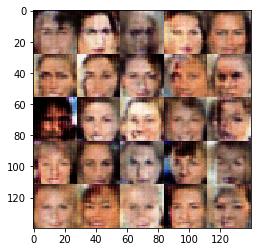

Epoch 1/1... Batch 710... Discriminator Loss: 1.3356... Generator Loss: 0.8243
Epoch 1/1... Batch 720... Discriminator Loss: 1.2826... Generator Loss: 0.9584
Epoch 1/1... Batch 730... Discriminator Loss: 1.3228... Generator Loss: 1.0950
Epoch 1/1... Batch 740... Discriminator Loss: 1.3113... Generator Loss: 0.7672
Epoch 1/1... Batch 750... Discriminator Loss: 1.1942... Generator Loss: 0.6611
Epoch 1/1... Batch 760... Discriminator Loss: 1.2551... Generator Loss: 0.8723
Epoch 1/1... Batch 770... Discriminator Loss: 1.3006... Generator Loss: 0.7923
Epoch 1/1... Batch 780... Discriminator Loss: 1.1649... Generator Loss: 1.1275
Epoch 1/1... Batch 790... Discriminator Loss: 1.2895... Generator Loss: 0.9462
Epoch 1/1... Batch 800... Discriminator Loss: 1.2619... Generator Loss: 0.6775


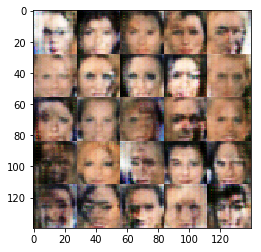

Epoch 1/1... Batch 810... Discriminator Loss: 1.4320... Generator Loss: 0.5271
Epoch 1/1... Batch 820... Discriminator Loss: 1.3922... Generator Loss: 1.3111
Epoch 1/1... Batch 830... Discriminator Loss: 1.2142... Generator Loss: 0.8795
Epoch 1/1... Batch 840... Discriminator Loss: 1.1564... Generator Loss: 1.0634
Epoch 1/1... Batch 850... Discriminator Loss: 1.2706... Generator Loss: 0.8722
Epoch 1/1... Batch 860... Discriminator Loss: 1.3541... Generator Loss: 1.1655
Epoch 1/1... Batch 870... Discriminator Loss: 1.3067... Generator Loss: 0.8616
Epoch 1/1... Batch 880... Discriminator Loss: 1.2468... Generator Loss: 0.7755
Epoch 1/1... Batch 890... Discriminator Loss: 1.0530... Generator Loss: 0.8439
Epoch 1/1... Batch 900... Discriminator Loss: 0.8422... Generator Loss: 1.0857


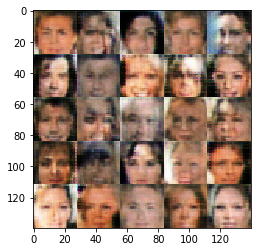

Epoch 1/1... Batch 910... Discriminator Loss: 1.1504... Generator Loss: 0.9646
Epoch 1/1... Batch 920... Discriminator Loss: 1.1609... Generator Loss: 1.2335
Epoch 1/1... Batch 930... Discriminator Loss: 1.1811... Generator Loss: 0.8138
Epoch 1/1... Batch 940... Discriminator Loss: 0.9627... Generator Loss: 0.9764
Epoch 1/1... Batch 950... Discriminator Loss: 0.9140... Generator Loss: 0.9706
Epoch 1/1... Batch 960... Discriminator Loss: 1.4916... Generator Loss: 0.4216
Epoch 1/1... Batch 970... Discriminator Loss: 1.2321... Generator Loss: 0.6295
Epoch 1/1... Batch 980... Discriminator Loss: 1.1528... Generator Loss: 0.9131
Epoch 1/1... Batch 990... Discriminator Loss: 0.9757... Generator Loss: 1.0065
Epoch 1/1... Batch 1000... Discriminator Loss: 1.5214... Generator Loss: 0.4396


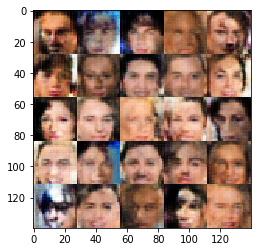

Epoch 1/1... Batch 1010... Discriminator Loss: 1.3677... Generator Loss: 0.5198
Epoch 1/1... Batch 1020... Discriminator Loss: 1.1187... Generator Loss: 1.1744
Epoch 1/1... Batch 1030... Discriminator Loss: 1.0329... Generator Loss: 0.9499
Epoch 1/1... Batch 1040... Discriminator Loss: 1.2856... Generator Loss: 0.7098
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2595... Generator Loss: 0.7745
Epoch 1/1... Batch 1060... Discriminator Loss: 1.3282... Generator Loss: 0.5163
Epoch 1/1... Batch 1070... Discriminator Loss: 1.3545... Generator Loss: 0.5272
Epoch 1/1... Batch 1080... Discriminator Loss: 1.2857... Generator Loss: 0.9050
Epoch 1/1... Batch 1090... Discriminator Loss: 1.2232... Generator Loss: 0.8739
Epoch 1/1... Batch 1100... Discriminator Loss: 1.2766... Generator Loss: 0.6668


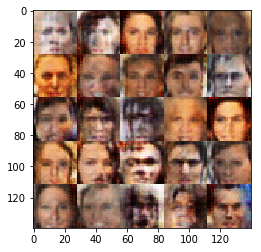

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2884... Generator Loss: 0.9125
Epoch 1/1... Batch 1120... Discriminator Loss: 1.3073... Generator Loss: 0.8566
Epoch 1/1... Batch 1130... Discriminator Loss: 1.5317... Generator Loss: 0.5344
Epoch 1/1... Batch 1140... Discriminator Loss: 1.2608... Generator Loss: 0.7088
Epoch 1/1... Batch 1150... Discriminator Loss: 1.2120... Generator Loss: 0.8216
Epoch 1/1... Batch 1160... Discriminator Loss: 1.0360... Generator Loss: 0.8039
Epoch 1/1... Batch 1170... Discriminator Loss: 1.2579... Generator Loss: 1.0353
Epoch 1/1... Batch 1180... Discriminator Loss: 1.0971... Generator Loss: 1.1215
Epoch 1/1... Batch 1190... Discriminator Loss: 1.0279... Generator Loss: 0.7993
Epoch 1/1... Batch 1200... Discriminator Loss: 1.4589... Generator Loss: 0.7161


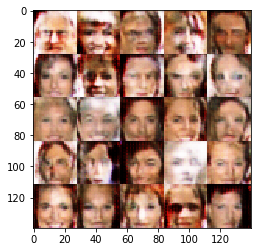

Epoch 1/1... Batch 1210... Discriminator Loss: 1.0231... Generator Loss: 0.8194
Epoch 1/1... Batch 1220... Discriminator Loss: 1.1472... Generator Loss: 0.7226
Epoch 1/1... Batch 1230... Discriminator Loss: 1.2818... Generator Loss: 0.6797
Epoch 1/1... Batch 1240... Discriminator Loss: 1.1755... Generator Loss: 1.4929
Epoch 1/1... Batch 1250... Discriminator Loss: 1.1927... Generator Loss: 0.8539
Epoch 1/1... Batch 1260... Discriminator Loss: 1.2445... Generator Loss: 0.9066
Epoch 1/1... Batch 1270... Discriminator Loss: 1.5383... Generator Loss: 0.4384
Epoch 1/1... Batch 1280... Discriminator Loss: 1.2871... Generator Loss: 0.8317
Epoch 1/1... Batch 1290... Discriminator Loss: 1.2783... Generator Loss: 0.8988
Epoch 1/1... Batch 1300... Discriminator Loss: 1.5689... Generator Loss: 0.9319


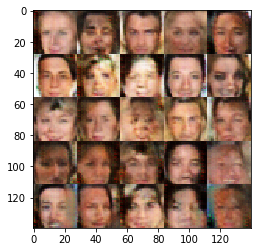

Epoch 1/1... Batch 1310... Discriminator Loss: 1.1054... Generator Loss: 0.7686
Epoch 1/1... Batch 1320... Discriminator Loss: 1.2825... Generator Loss: 1.0981
Epoch 1/1... Batch 1330... Discriminator Loss: 1.2691... Generator Loss: 0.9040
Epoch 1/1... Batch 1340... Discriminator Loss: 1.2146... Generator Loss: 0.8279
Epoch 1/1... Batch 1350... Discriminator Loss: 1.2845... Generator Loss: 1.4932
Epoch 1/1... Batch 1360... Discriminator Loss: 1.5190... Generator Loss: 0.5148
Epoch 1/1... Batch 1370... Discriminator Loss: 1.2806... Generator Loss: 0.9993
Epoch 1/1... Batch 1380... Discriminator Loss: 1.5756... Generator Loss: 0.4374
Epoch 1/1... Batch 1390... Discriminator Loss: 1.2692... Generator Loss: 0.9489
Epoch 1/1... Batch 1400... Discriminator Loss: 1.1588... Generator Loss: 0.8894


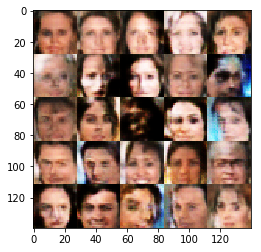

Epoch 1/1... Batch 1410... Discriminator Loss: 0.9944... Generator Loss: 0.9603
Epoch 1/1... Batch 1420... Discriminator Loss: 1.3442... Generator Loss: 0.8664
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2779... Generator Loss: 0.9933
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3273... Generator Loss: 1.1354
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2068... Generator Loss: 0.7744
Epoch 1/1... Batch 1460... Discriminator Loss: 1.3590... Generator Loss: 0.6421
Epoch 1/1... Batch 1470... Discriminator Loss: 1.2820... Generator Loss: 1.0485
Epoch 1/1... Batch 1480... Discriminator Loss: 1.1923... Generator Loss: 0.8840
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3053... Generator Loss: 0.9392
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2956... Generator Loss: 0.7117


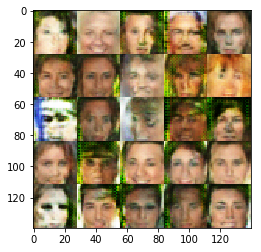

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2490... Generator Loss: 0.8853
Epoch 1/1... Batch 1520... Discriminator Loss: 1.4579... Generator Loss: 0.6444
Epoch 1/1... Batch 1530... Discriminator Loss: 1.3115... Generator Loss: 0.7109
Epoch 1/1... Batch 1540... Discriminator Loss: 1.4428... Generator Loss: 0.8971
Epoch 1/1... Batch 1550... Discriminator Loss: 1.2597... Generator Loss: 0.7042
Epoch 1/1... Batch 1560... Discriminator Loss: 1.2959... Generator Loss: 0.6637
Epoch 1/1... Batch 1570... Discriminator Loss: 1.1019... Generator Loss: 0.8399
Epoch 1/1... Batch 1580... Discriminator Loss: 1.2716... Generator Loss: 0.6741
Epoch 1/1... Batch 1590... Discriminator Loss: 1.1320... Generator Loss: 0.8780
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3294... Generator Loss: 0.7168


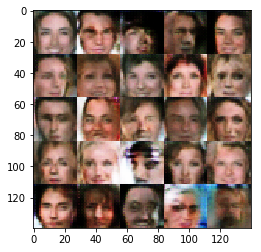

Epoch 1/1... Batch 1610... Discriminator Loss: 1.5152... Generator Loss: 0.8329
Epoch 1/1... Batch 1620... Discriminator Loss: 1.1397... Generator Loss: 0.8061
Epoch 1/1... Batch 1630... Discriminator Loss: 1.1317... Generator Loss: 0.8903
Epoch 1/1... Batch 1640... Discriminator Loss: 1.4214... Generator Loss: 0.5019
Epoch 1/1... Batch 1650... Discriminator Loss: 1.2305... Generator Loss: 0.9012
Epoch 1/1... Batch 1660... Discriminator Loss: 1.1838... Generator Loss: 0.7997
Epoch 1/1... Batch 1670... Discriminator Loss: 1.0675... Generator Loss: 0.8424
Epoch 1/1... Batch 1680... Discriminator Loss: 1.2388... Generator Loss: 0.7269
Epoch 1/1... Batch 1690... Discriminator Loss: 1.2274... Generator Loss: 0.6620
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3589... Generator Loss: 0.6466


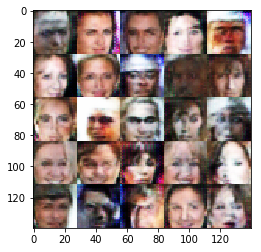

Epoch 1/1... Batch 1710... Discriminator Loss: 1.4070... Generator Loss: 1.0599
Epoch 1/1... Batch 1720... Discriminator Loss: 1.2202... Generator Loss: 0.9148
Epoch 1/1... Batch 1730... Discriminator Loss: 1.2804... Generator Loss: 0.7347
Epoch 1/1... Batch 1740... Discriminator Loss: 1.3561... Generator Loss: 0.8899
Epoch 1/1... Batch 1750... Discriminator Loss: 1.1345... Generator Loss: 1.0484
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1197... Generator Loss: 0.8831
Epoch 1/1... Batch 1770... Discriminator Loss: 1.4284... Generator Loss: 0.6169
Epoch 1/1... Batch 1780... Discriminator Loss: 1.4171... Generator Loss: 0.4757
Epoch 1/1... Batch 1790... Discriminator Loss: 1.4173... Generator Loss: 0.7271
Epoch 1/1... Batch 1800... Discriminator Loss: 1.2070... Generator Loss: 0.8071


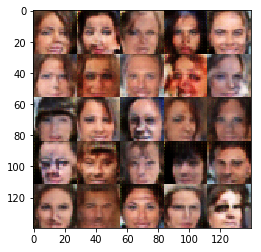

Epoch 1/1... Batch 1810... Discriminator Loss: 1.2668... Generator Loss: 0.7854
Epoch 1/1... Batch 1820... Discriminator Loss: 1.2538... Generator Loss: 0.7563
Epoch 1/1... Batch 1830... Discriminator Loss: 1.3521... Generator Loss: 0.6034
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1111... Generator Loss: 0.9632
Epoch 1/1... Batch 1850... Discriminator Loss: 1.3698... Generator Loss: 0.7260
Epoch 1/1... Batch 1860... Discriminator Loss: 1.1817... Generator Loss: 0.7529
Epoch 1/1... Batch 1870... Discriminator Loss: 1.4076... Generator Loss: 0.5603
Epoch 1/1... Batch 1880... Discriminator Loss: 1.4204... Generator Loss: 0.4976
Epoch 1/1... Batch 1890... Discriminator Loss: 1.2838... Generator Loss: 1.0925
Epoch 1/1... Batch 1900... Discriminator Loss: 1.1149... Generator Loss: 0.9237


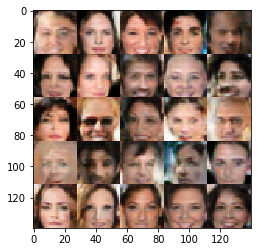

Epoch 1/1... Batch 1910... Discriminator Loss: 1.1592... Generator Loss: 0.7719
Epoch 1/1... Batch 1920... Discriminator Loss: 1.1775... Generator Loss: 0.9103
Epoch 1/1... Batch 1930... Discriminator Loss: 1.3853... Generator Loss: 0.6705
Epoch 1/1... Batch 1940... Discriminator Loss: 1.2461... Generator Loss: 0.8864
Epoch 1/1... Batch 1950... Discriminator Loss: 1.2591... Generator Loss: 0.5656
Epoch 1/1... Batch 1960... Discriminator Loss: 1.2080... Generator Loss: 0.7951
Epoch 1/1... Batch 1970... Discriminator Loss: 1.3533... Generator Loss: 0.7521
Epoch 1/1... Batch 1980... Discriminator Loss: 1.2240... Generator Loss: 0.7689
Epoch 1/1... Batch 1990... Discriminator Loss: 1.4040... Generator Loss: 0.7349
Epoch 1/1... Batch 2000... Discriminator Loss: 1.2134... Generator Loss: 0.8542


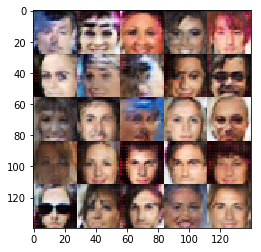

Epoch 1/1... Batch 2010... Discriminator Loss: 1.3462... Generator Loss: 0.6528
Epoch 1/1... Batch 2020... Discriminator Loss: 1.4386... Generator Loss: 0.7587


In [63]:
batch_size = 100
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。